In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fmin_cg
import scipy.io as si
plt.rcParams['axes.formatter.limits'] = [-3,3]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1 Mulit-class Classification

## 1.2 Visualizing the data set

In [2]:
a = si.loadmat('ex3_octave/ex3data1.mat')
X = a['X']
y = a['y'].flatten()

# replace 10 -> 0 because Matlab is stupid
y[np.flatnonzero(y==10)] = 0

In [3]:
def displayData(X):
    
    # set up array
    fig, axarr = plt.subplots(nrows=10, ncols=10,
                              figsize=(10,10))
    
    # loop over randomly drawn numbers
    for ii in range(10):
        for jj in range(10):
            ind = np.random.randint(X.shape[0])
            tmp = X[ind,:].reshape(20,20, order='F')
            axarr[ii,jj].imshow(tmp, cmap='gray_r')
            plt.setp(axarr[ii,jj].get_xticklabels(), visible=False)
            plt.setp(axarr[ii,jj].get_yticklabels(), visible=False)
    
    fig.subplots_adjust(hspace=0, wspace=0)


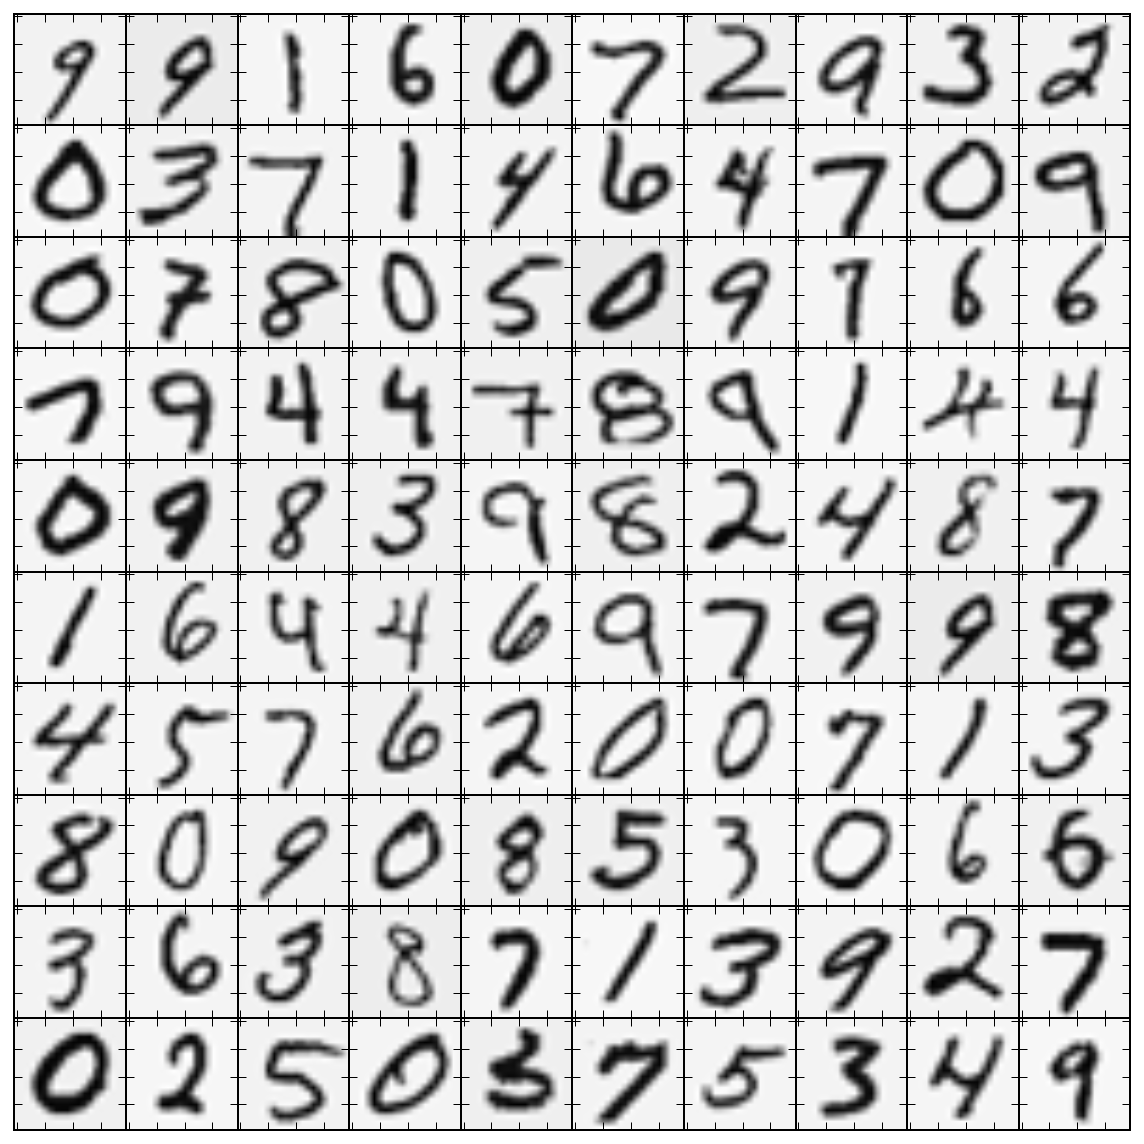

In [4]:
displayData(X)

## 1.3 Vectorizing Logistic Regression

In [5]:
def sigmoid(z):
    
    return 1 / (1 + np.exp(-z))

In [6]:
def compute_cost_reg(theta, X, y, lam):
    
    # make an array of lambdas 
    lamarray = np.ones(len(theta)) * lam
    
    # zero out first element so se don't regularize constant term
    lamarray[0] = 0.0
    
    # number of training samples
    m = len(y)  
    
    # tolerance for sigmoid function.
    # i.e., 1-htheta cannot be less than 1e-15
    # this fixes loss of precision errors
    eps = 1e-15
    
    # compute the hypothesis
    htheta = sigmoid(np.dot(X, theta))
        
    # compute J in three terms
    term1 = np.dot(np.log(htheta), y)
    term2 = np.dot(np.log(1-htheta+eps), (1-y))
    term3 =  1 / 2  * np.sum(lamarray*theta**2)
    
    # cost function
    J = - 1 / m * (term1 + term2 - term3) 
    
    return J

def compute_grad_reg(theta, X, y, lam):
    
     # make an array of lambdas 
    lamarray = np.ones(len(theta)) * lam
    
    # zero out first element so se don't regularize constant term
    lamarray[0] = 0.0
    
    # number of training samples
    m = len(y)
        
    # compute the hypothesis
    htheta = sigmoid(np.dot(X, theta))
        
    # gradient
    grad = (np.dot(X.T, (htheta - y)) + lamarray * theta) / m
            
    return grad
    
    
def costFunctionReg(theta, X, y, lam):
    
    # use auxiliary cost function
    J = compute_cost_reg(theta, X, y, lam)
    
    # use auxiliary gradient function
    grad = compute_grad_reg(theta, X, y, lam)
    
    return J, grad

## 1.4 One-vs-all Classification

In [12]:
def oneVsAll(X, y, num_labels, lam):
    
    # sizes
    m, n = X.shape
    
    # parameter array
    all_theta = np.zeros((num_labels, n+1))
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
    
    # labels
    labels = np.arange(0, 10)
    
    for ct, lab in enumerate(labels):
        
        ynew = np.array(y==lab, dtype='int').flatten()
        
        # set up bfgs minimization for label
        all_theta[ct,:] = fmin_cg(compute_cost_reg, all_theta[ct,:], 
                                    fprime=compute_grad_reg, maxiter=9000, 
                                    args=(X, ynew, lam), disp=False)
        
    return all_theta
        

In [15]:
def predictOneVsAll(all_theta, X):
    
    # sizes
    m, n = X.shape
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
    
    # model
    htheta = sigmoid(np.dot(X, all_theta.T))
    
    # return the model index
    p = np.argmax(htheta, axis=1)
    
    return p

In [14]:
# train one-vs-all classifier
lam = 0.1
all_theta = oneVsAll(X, y, 10, lam)

In [16]:
# get predictions for each set
p = predictOneVsAll(all_theta, X)

In [19]:
print 'Training set Accuracy: %2.2f percent' % (np.mean(p==y)*100)

Training set Accuracy: 96.44 percent


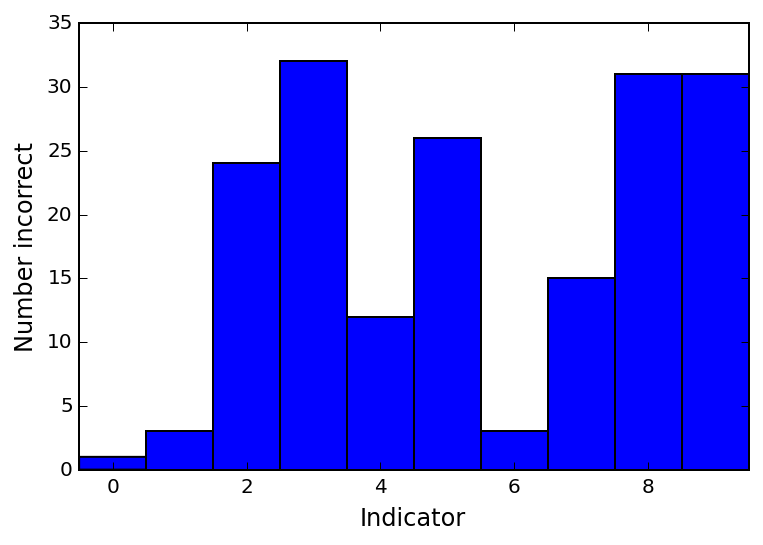

In [30]:
# find the incorrect examples and plot them
ic = np.flatnonzero(p!=y)
plt.hist(y[ic], len(np.unique(y[ic])), range=(-0.5, 9.5))
plt.xlim(-0.5, 9.5)
plt.xlabel('Indicator')
plt.ylabel('Number incorrect')

# 2 Neural Networks

## 2.1 Model Representation

In [47]:
# read in pre-computed weights
a = si.loadmat('ex3_octave/ex3weights.mat')
Theta1 = a['Theta1']
Theta2 = a['Theta2']

In [62]:
# read in data again but this time don't change 10 -> 0
a = si.loadmat('ex3_octave/ex3data1.mat')
X = a['X']
y = a['y'].flatten()

## 2.2 Feedforward Propagation and Prediction

In [72]:
def predict(Theta1, Theta2, X):
    
    # sizes
    m, n = X.shape
    num_labels = Theta2.shape[0]
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
        
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)

    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    p = np.argmax(a3, axis=1)
    
    return p
    

In [73]:
p = predict(Theta1, Theta2, X)

In [74]:
print 'Training set Accuracy: %2.2f percent' % (np.mean(p+1==y)*100)

Training set Accuracy: 97.52 percent
